In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext Cython
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [9]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import RankingClassBase

import pandas as pd
import numpy as np
import scipy
import time
import glob
from pandas.tseries.offsets import *

In [3]:
swarm_file = 'EP_BearishCollarBrokenWing_Short_BollingerBands'

# Real swarm from .swm
swm = Swarm.load('/home/ubertrader/Dropbox/tmqrexo/tmqrv/notebooks/tmp/temp_swarms/'+swarm_file+'.swm')
df = swm.raw_swarm

In [4]:
%%cython -a
cimport cython
import numpy as np
import pandas as pd
cimport numpy as np
DTYPE_float = np.float
ctypedef np.float64_t DTYPE_t_float
ctypedef np.uint64_t DTYPE_t_uint64
ctypedef np.uint8_t DTYPE_t_uint8
from libc.math cimport abs

np.import_array()


@cython.cdivision(True)
@cython.boundscheck(False)
def btfunc(df):
    
    # Calculate trade-by-trade payoffs
    cdef float netprofit = 0.0    
    cdef float sumwin = 0.0
    cdef float sumloss = 0.0
    cdef float wincount = 0.0
    cdef float tradescount = 0.0
    cdef float eqhigh = 0.0
    cdef float maxdd = 0.0
    cdef float px_chg = 0.0

    
    cdef np.ndarray[DTYPE_t_float, ndim=1] px = df.values
    cdef int barcount = px.shape[0]

    cdef int i = 1
    
    for i in range(1, barcount):
        px_chg = px[i] - px[i-1]
        
        netprofit += px_chg
        
        eqhigh = max(eqhigh, netprofit)
        maxdd = min(maxdd, netprofit - eqhigh)
        
        if px_chg > 0:
            wincount += 1.0
            sumwin += px_chg
        else:
            sumloss += px_chg                     
        
        tradescount += 1.0

    try:
        modsharpe = np.mean(px) / np.std(px)
    except ZeroDivisionError:
        modsharpe = np.nan
    
    return {'strategy': df.name,
            'stats_pricechange_modsharpe': modsharpe, 
            'stats_netprofit': netprofit,
            'stats_max_dd': maxdd, 
            'stats_recovery_factor': netprofit / abs(maxdd),
            'stats_profit_factor': sumwin / abs(sumloss), 
            'stats_winrate': wincount / tradescount
            }



In [5]:
btfunc

<function _cython_magic_1388464f3b1596c4d05b1c015b14e8f7.btfunc>

In [21]:
from scipy.stats.stats import pearsonr

class RankerBestWithCorrel(RankingClassBase):
    def __init__(self, window_size=-1, correl_threshold=0.5):
        self.window_size = window_size
        self.correl_threshold = correl_threshold

    def clear(self):
        pass
         
        
    def rank(self, swarm_slice, nsystems):
        result = []
        rank_info = []

        # Filter all negative equities
        ss =  swarm_slice[(swarm_slice.iloc[-1][(swarm_slice.iloc[-1] > 0)]).index]      
        if len(ss.columns) == 0:
            return [], []

        # Applying simple backtesting function
        #bt_data = ss.apply(self.btfunc)
        bt_data = ss.apply(btfunc)
        
        # Creating dataframe for new backtest metrics values
        stats_df = pd.DataFrame([x for x in bt_data])
        stats_df = stats_df.set_index('strategy')
        
        
        # Calculating ranking for Sum(ranks)
        best_stats = (stats_df.rank(pct=True)).sum(axis=1).sort_values(ascending=False)
        
        if not np.isnan(best_stats[0]) and best_stats[0] <= 0:
            return [],[]

        # Picking N best system with low correlation
        best_systems = []
        best_systems.append(best_stats.index[0])
        
        i = 1
        corr_threshold = self.correl_threshold

        while i < len(best_stats) and len(best_systems) < nsystems:
            best = best_systems[-1]
            candidate = best_stats.index[i]            
            # Calculate Pearson correlation of equity lines
            corr = pearsonr(ss[best].values, ss[candidate].values)[0]
            
            # If correlation between last and candidate system equity < threshold
            if not np.isnan(corr) and corr < corr_threshold:
                best_systems.append(candidate)
            i += 1
        
        rank_info = {
            'start_of_window': ss.index[0],
            'end_of_window': ss.index[-1],
            'corr_matrix': ss[best_systems].corr()
        }
        
        return best_systems, rank_info
    
    

[autoreload of backtester.swarms.rankingclasses failed: Traceback (most recent call last):
  File "/home/ubertrader/anaconda3/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'backtest_equity'
]


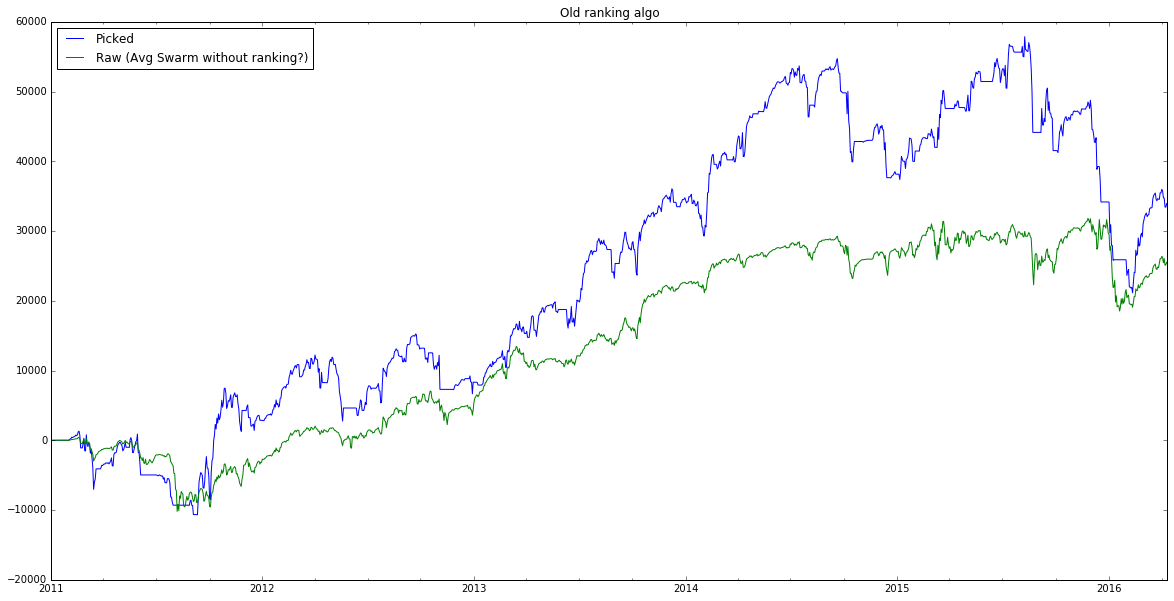

In [10]:
title('Old ranking algo')
swm.picked_equity.plot(label='Picked')
swm.raw_equity.plot(label='Raw (Avg Swarm without ranking?)')
legend(loc=2)

Elapsed: 124.92383980751038


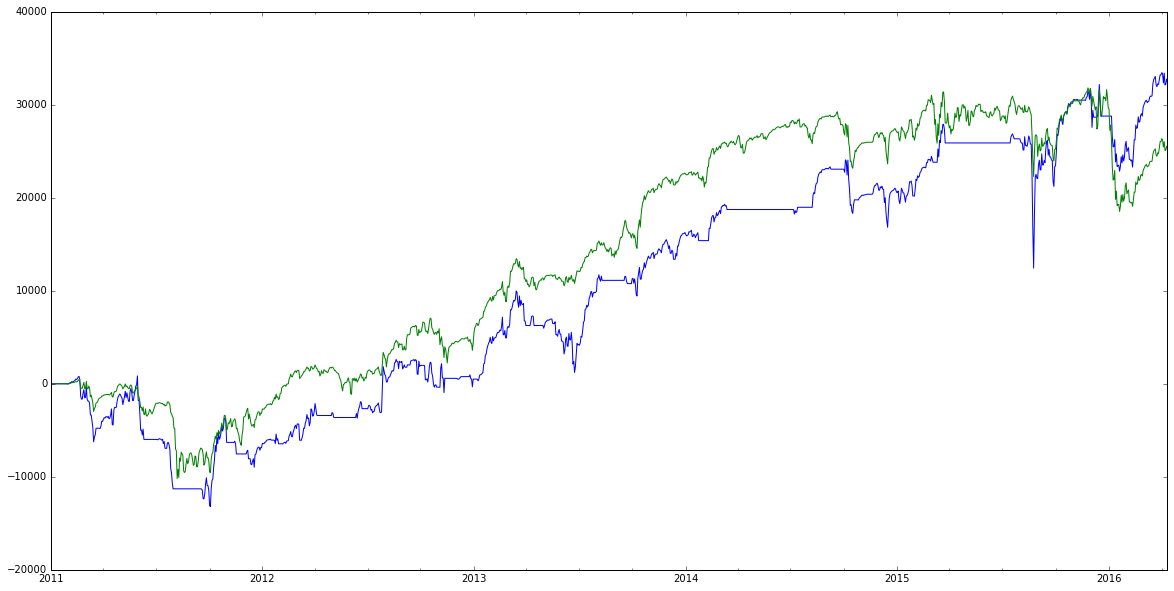

In [11]:
begin_time = time.time()
swm.context['swarm']['members_count'] = 3
swm.context['swarm']['ranking_class'] = RankerBestWithCorrel()

swm.pick()
print("Elapsed: {0}".format(time.time() - begin_time))
swm.picked_equity.plot(label='Picked')
swm.raw_equity.plot(label='Raw (Avg Swarm without ranking?)')

In [20]:
swm.picked_swarm.iloc[-100000:]

,0,1,2
2011-01-03,0.0,0.0,0.0
2011-01-04,0.0,0.0,0.0
2011-01-05,0.0,0.0,0.0
2011-01-06,0.0,0.0,0.0
2011-01-07,0.0,0.0,0.0
2011-01-10,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0
2011-01-14,0.0,0.0,0.0


In [22]:
ranker = RankerBestWithCorrel()

%lprun -f ranker.rank ranker.rank(swm.raw_swarm.iloc[0:500,:], 3)

In [23]:
ranker.rank(swm.raw_swarm.iloc[0:500,:], 3)

(['(-1, 20, 3, 24, 15)', '(-1, 30, 5, 17, 1)', '(-1, 30, 5, 20, 4)'],
 {'corr_matrix':                      (-1, 20, 3, 24, 15)  (-1, 30, 5, 17, 1)  \
  (-1, 20, 3, 24, 15)             1.000000            0.236412   
  (-1, 30, 5, 17, 1)              0.236412            1.000000   
  (-1, 30, 5, 20, 4)              0.866065            0.127911   
  
                       (-1, 30, 5, 20, 4)  
  (-1, 20, 3, 24, 15)            0.866065  
  (-1, 30, 5, 17, 1)             0.127911  
  (-1, 30, 5, 20, 4)             1.000000  ,
  'end_of_window': Timestamp('2012-11-30 00:00:00', offset='B'),
  'start_of_window': Timestamp('2011-01-03 00:00:00', offset='B')})